# Texture Synthesis Tutorial

### based on 2001 Efron & Freeman paper

In [10]:
# Run this cell by pressing "Shift + Enter" - this will download and extract the
# files needed for this tutorial.

# first, download the script to obtain the files from Google Drive
!wget ftp://68.183.140.238/download_google_drive_texture_analysis_files.sh

# now, run the script to download and extract the files
!bash download_google_drive_texture_analysis_files.sh

--2018-11-26 00:14:11--  ftp://68.183.140.238/download_google_drive_texture_analysis_files.sh
           => ‘download_google_drive_texture_analysis_files.sh’
Connecting to 68.183.140.238:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD not needed.
==> SIZE download_google_drive_texture_analysis_files.sh ... 845
==> PASV ... done.    ==> RETR download_google_drive_texture_analysis_files.sh ... done.
Length: 845 (unauthoritative)

download_google_dri 100%[===================>]     845  --.-KB/s    in 0s      

2018-11-26 00:14:12 (80.2 MB/s) - ‘download_google_drive_texture_analysis_files.sh’ saved [845]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    561      0 --:--:-- --:--:-- --:--:--   561
100 1613k  100 1613k    0     0  1932k      0 --:--:-- --:--:-- --:--:-- 19

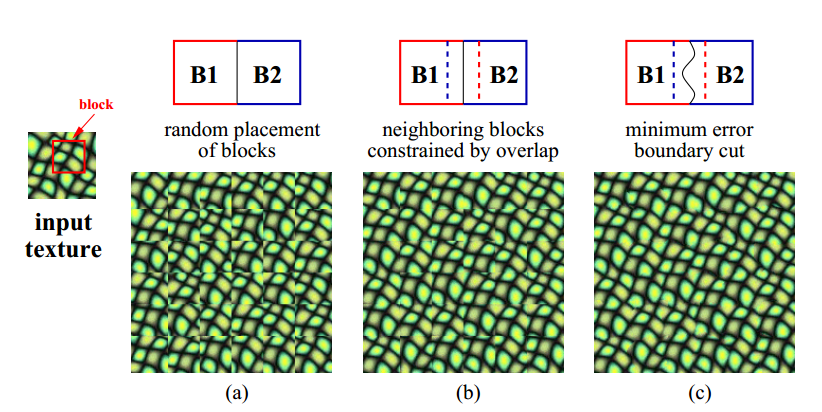

In [0]:
from skimage.io import imread, imsave
from os.path import normpath as fn
import numpy as np
import matplotlib.pyplot as plt

In [0]:
##initialize output image parameters
img = np.float32(imread(fn('input/strawberry.jpg')))/255.
img = img[:200,:200,:]
H, W, C = img.shape

block_size = 20
n_patch = 10
overlap_width = 7

# Functions: calculate the error of overlapped regions for all possible patches

In [0]:
def left_error(img,output,ind_pc):
    left_error = np.zeros((H-block_size,W-block_size))
    output_overlap = output[ind_pc[0]*(block_size-overlap_width): ind_pc[0]*(block_size-overlap_width)+block_size,\
                            ind_pc[1]*(block_size-overlap_width): ind_pc[1]*(block_size-overlap_width)+overlap_width,:]
    for i in range(H-block_size):
        for j in range(W-block_size):
            img_overlap = img[i: i+block_size, j: j+overlap_width,:]
            left_error[i,j] = np.sum((img_overlap - output_overlap)**2)

    return left_error

def up_error(img,output,ind_pc):
    up_error = np.zeros((H-block_size,W-block_size))
    output_overlap = output[ind_pc[0]*(block_size-overlap_width): ind_pc[0]*(block_size-overlap_width)+overlap_width,\
                            ind_pc[1]*(block_size-overlap_width): ind_pc[1]*(block_size-overlap_width)+block_size,:]
    for i in range(H-block_size):
        for j in range(W-block_size):
            img_overlap = img[i: i+overlap_width, j: j+block_size,:]
            up_error[i,j] = np.sum((img_overlap - output_overlap)**2)

    return up_error

# Function: find the best matched patch

In [0]:
def best_patch(ind_pc):
    #ind_pc is the index of patch, e.g. [0,1] means first row, second column patch
    if (ind_pc[0]==0) & (ind_pc[1]>0):
        error = left_error(img,output,ind_pc)
    elif (ind_pc[0]>0) & (ind_pc[1]==0):
        error = up_error(img, output, ind_pc)
    else:
        error = up_error(img,output,ind_pc)+left_error(img,output,ind_pc)
    
    error[error==0] = 100
    
    min_error = np.min(error)
    px_list = np.where(error<=min_error*1.1)
    
    return px_list

# Function: calculate the pixel-wise error of overlapped regions for the selected patch

In [0]:
def vertical_cost(patch, output, ind_pc):
    
    vertical_cost = np.zeros((block_size,overlap_width))
    output_overlap = output[ind_pc[0]*(block_size-overlap_width): ind_pc[0]*(block_size-overlap_width)+block_size,\
                            ind_pc[1]*(block_size-overlap_width): ind_pc[1]*(block_size-overlap_width)+overlap_width,:]
    
    patch_overlap = patch[0: block_size, 0: overlap_width,:]
    
    vertical_cost = np.sum((output_overlap-patch_overlap)**2,axis=2)
    
    return vertical_cost

def horizontal_cost(patch, output, ind_pc):
    
    horizontal_cost = np.zeros((overlap_width,block_size))
    output_overlap = output[ind_pc[0]*(block_size-overlap_width): ind_pc[0]*(block_size-overlap_width)+overlap_width,\
                            ind_pc[1]*(block_size-overlap_width): ind_pc[1]*(block_size-overlap_width)+block_size,:]
    
    patch_overlap = patch[0: overlap_width, 0: block_size,:]
    
    horizontal_cost = np.sum((output_overlap-patch_overlap)**2,axis=2)
    
    return horizontal_cost

# Function: find the optimal cut 

In [0]:
def vertical_cut(vertical_cost):
    
    d = np.zeros((block_size, overlap_width),dtype=int)
    d[0,:] = np.arange(overlap_width,dtype=int)
    err = vertical_cost[0,:]
    
    for i in range(1,block_size):
        for j in range(overlap_width):
            if d[i-1,j]==0:
                d[i,j] = d[i-1,j] + np.argmin([vertical_cost[i,d[i-1,j]], vertical_cost[i,d[i-1,j]+1]])
            
            elif d[i-1,j]==overlap_width-1:
                d[i,j] = d[i-1,j] -1 + np.argmin([vertical_cost[i,d[i-1,j]-1], vertical_cost[i,d[i-1,j]]])
               
            else:
                d[i,j] = d[i-1,j] -1 + np.argmin([vertical_cost[i,d[i-1,j]-1], vertical_cost[i,d[i-1,j]], vertical_cost[i,d[i-1,j]+1]])
            
        err += vertical_cost[i,d[i,:]]
    
    ind = np.argmin(err)
    vertical_cut = d[:,ind] 
    
    return vertical_cut

def horizontal_cut(horizontal_cost):
    
    d = np.zeros((overlap_width,block_size),dtype=int)
    d[:,0] = np.arange(overlap_width,dtype=int)
    err = horizontal_cost[:,0]
    
    for i in range(1,block_size):
        for j in range(overlap_width):
            if d[j,i-1]==0:
                d[j,i] = d[j,i-1] + np.argmin([horizontal_cost[d[j,i-1],i], horizontal_cost[d[j,i-1]+1,i]])
            
            elif d[j,i-1]==overlap_width-1:
                d[j,i] = d[j,i-1] -1 + np.argmin([horizontal_cost[d[j,i-1]-1,i], horizontal_cost[d[j,i-1],i]])
               
            else:
                d[j,i] = d[j,i-1] -1 + np.argmin([horizontal_cost[d[j,i-1]-1,i], horizontal_cost[d[j,i-1],i],horizontal_cost[d[j,i-1]+1,i]])
            
        err += horizontal_cost[d[:,i],i]
    
    ind = np.argmin(err)
    horizontal_cut = d[ind,:] 
    
    return horizontal_cut


# Function: quilt patches together

In [0]:
def quilt_vertical(vertical_cut,patch, ind_pc):
    for i in range(block_size):
        patch[i,:vertical_cut[i],:] = output[ind_pc[0]*(block_size-overlap_width)+i, \
                                           ind_pc[1]*(block_size-overlap_width):vertical_cut[i] + ind_pc[1]*(block_size-overlap_width),:]
    return patch

def quilt_horizontal(horizontal_cut,patch, ind_pc):
    for i in range(block_size):
        patch[:horizontal_cut[i],i,:] = output[ind_pc[0]*(block_size-overlap_width):horizontal_cut[i] + ind_pc[0]*(block_size-overlap_width), \
                                              ind_pc[1]*(block_size-overlap_width)+i,:]
    return patch


# Generate the output picture with previously defined functions

In [0]:
output_size = int((block_size-overlap_width)*n_patch + overlap_width)  #initialize output image

output = np.zeros((output_size,output_size,3))
y = np.random.randint(0,H-block_size)
x = np.random.randint(0,W-block_size)
output[:block_size, :block_size,:] = img[y:y+block_size, x:x+block_size,:]

for i in range(n_patch):
    for j in range(n_patch):
        ind_pc = [i,j]
        #print(i,j)

        if (i!=0) | (j!=0):
            px_list = best_patch(ind_pc)
            rand_pick = np.random.randint(len(px_list[0]))
            x1 = px_list[0][rand_pick]
            y1 = px_list[1][rand_pick]
            
            patch = img[x1:x1+block_size,y1:y1+block_size,:].copy()
            
            if i==0:
            #only need vertical quilt
                vcost = vertical_cost(patch,output, ind_pc) 
                vcut = vertical_cut(vcost)
                patch_new = quilt_vertical(vcut,patch,ind_pc)

            elif j==0:
            #only need horizontal quilt
                hcost = horizontal_cost(patch,output, ind_pc) 
                hcut = horizontal_cut(hcost)
                patch_new = quilt_horizontal(hcut,patch,ind_pc)
                
            else:
                vcost = vertical_cost(patch,output, ind_pc) 
                vcut = vertical_cut(vcost)
                patch_new = quilt_vertical(vcut,patch,ind_pc)

                hcost = horizontal_cost(patch_new,output, ind_pc) 
                hcut = horizontal_cut(hcost)
                patch_new = quilt_horizontal(hcut,patch_new,ind_pc)

            output[i*(block_size-overlap_width):i*(block_size-overlap_width)+block_size, \
                   j*(block_size-overlap_width):j*(block_size-overlap_width)+block_size] = patch_new
                


# Plot the output picture

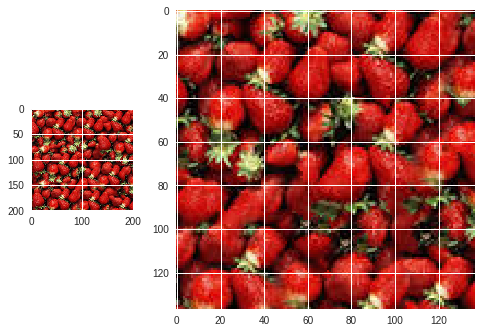

In [22]:
f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 3]})

a0.imshow(img)

a1.imshow(output)
plt.show()